# XGB Model Training and SHAP computation using the Synthetic-events Dataset

**Author: Tesfagabir Meharizghi<br>Last Updated: 01/25/2021**

In this experiment, we trained XGB models using HPO training from the different datasets. The main difference from previous experiments is that the intersection similarity adds all the events ending with `_A`, `_H` and `_U` as ground truth features. The former experiment/case considers only `_A` and `_H`.


Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- XGB

Dataset:
- Synthetic-events (Toy Dataset)

Requirements:
- Make sure that you have already generated multiple synthetic toy datasets (train/val/test splits) using [Create_toy_dataset_multiple.ipynb](../../data/toy_dataset/Create_toy_dataset_multiple.ipynb).

Notes:
- Helpers are available in both positive and negative events, that could balance out their effect
- If background = +ve/-ve/all ==> results of the SHAP importance is changing

Discussions/observations:
- The intersection similarity measure seems way better than the previous one. And the updated metric also gives a better measure to the quality of the computed important features. In our experiments, we could get more 80% in intersection similarity which was only in 30s in the previous experiments.

In [135]:
# pip install nb-black

In [136]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [137]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import sys

sys.path.append("../")

import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

import xgboost_utils as xgb_utils
import shap_jacc_utils as sj_utils

## XGB Model Training

### Constants

In [139]:
# Feature suffices that help predict the positive or negative class
HELPING_FEATURES_SUFFICES = ["_A", "_H", "_U"]  # Noises Removed

# Experiment number to run
# EXP_NUMBER = 1
# TUNING_JOB_NAME = "sagemaker-xgboost-210125-1347"

# EXP_NUMBER = 2
# TUNING_JOB_NAME = 'sagemaker-xgboost-210125-1423'

# EXP_NUMBER = 3
# TUNING_JOB_NAME = 'sagemaker-xgboost-210125-1504'

# EXP_NUMBER = 4
# TUNING_JOB_NAME = 'sagemaker-xgboost-210125-1524'

EXP_NUMBER = 5
TUNING_JOB_NAME = 'sagemaker-xgboost-210125-1547'

# Whether to preprocess data
PREPROCESS_DATA = False

# Whether to save SHAP scores
SAVE_SHAP_OUTPUT = True

# Whether to ouput SHAP explainer expected value
OUTPUT_SHAP_EXPLAINER = True

# Whether to shuffle val & test dataset for shap visualization purposes
SHUFFLE = True

# For seq_len=30
seq_len = 30

USE_FREQ = True  # Whether to use feature frequencies or one-hot for data preprocessing

nrows = 1e9

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

model_name = "xgb"
dataset = "Synthetic-events"

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = None  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = False  # If negative examples are used as background
BACKGROUND_POSITIVE_ONLY = False  # If positive examples are used as background
TEST_POSITIVE_ONLY = False  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = True  # Whether to consider the absolute value of a shap score #TODO: Check this before running.

train_data_path = f"../../../data/toy_dataset/data/{seq_len}/{EXP_NUMBER:02}/train.csv"
valid_data_path = f"../../../data/toy_dataset/data/{seq_len}/{EXP_NUMBER:02}/val.csv"
test_data_path = f"../../../data/toy_dataset/data/{seq_len}/{EXP_NUMBER:02}/test.csv"

model_save_path = (
    f"./output/{seq_len}/ExpIV/{EXP_NUMBER:02}/{model_name}/models/model_{'{}'}.pkl"
)
shap_save_path_pattern = f"./output/ExpIV/{seq_len}/{EXP_NUMBER:02}/{model_name}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

# Dataset preprocessing
x_train_one_hot_path = (
    f"output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/train_one_hot.csv"
)
x_valid_one_hot_path = (
    f"output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/val_one_hot.csv"
)
x_test_one_hot_path = (
    f"output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/test_one_hot.csv"
)

x_train_data_path = f"output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/train.csv"
x_valid_data_path = f"output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/val.csv"
x_test_data_path = f"output/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/test.csv"

s3_output_data_dir = (
    f"s3://merck-paper-bucket/{dataset}/ExpIV/{seq_len}/{EXP_NUMBER:02}/data"
)

# Model training
BUCKET = "merck-paper-bucket"
DATA_PREFIX = f"{dataset}/ExpIV/{seq_len}/{EXP_NUMBER:02}/data"
MODEL_PREFIX = f"{dataset}/ExpIV/{seq_len}/{EXP_NUMBER:02}/{model_name}".format(seq_len)
label = "label"

output_results_path = (
    f"output/ExpIV/{seq_len}/{EXP_NUMBER:02}/{model_name}/hpo_results/results.csv"
)

local_model_dir = f"output/ExpIV/{seq_len}/{EXP_NUMBER:02}/{model_name}/models/"
s3_output_path = f"s3://{BUCKET}/{MODEL_PREFIX}/output"

###Algorithm config
ALGORITHM = "xgboost"
REPO_VERSION = "1.2-1"

###Hyperparameter tuning config
TRAIN_INSTANCE_TYPE = "ml.m5.4xlarge"  #'ml.m4.16xlarge'
TRAIN_INSTANCE_COUNT = 1
MAX_PARALLEL_JOBS = 4
MAX_TRAIN_JOBS = 10

EVALUATION_METRIC = "auc"
OBJECTIVE = "binary:logistic"
OBJECTIVE_METRIC_NAME = "validation:auc"

# # Update hyperparameter ranges
# HYPERPARAMETER_RANGES = {
#     "eta": ContinuousParameter(0, 1),
#     "alpha": ContinuousParameter(0, 2),
#     "max_depth": IntegerParameter(1, 3),
# }

HYPERPARAMETER_RANGES = {
    "eta": ContinuousParameter(0.1, 0.3),  # (0.1, 0.5)
    "alpha": ContinuousParameter(0, 1),  # (0, 2)
    "max_depth": IntegerParameter(1, 2),  # (1, 10)
    "gamma": ContinuousParameter(0, 2),  # (0, 5),
    "num_round": IntegerParameter(20, 50),  # (200, 500), #(20, 50)
    "colsample_bylevel": ContinuousParameter(0.1, 0.2),  # (0.1, 1.0), #
    "colsample_bynode": ContinuousParameter(0.1, 0.3),  # (0.1, 1.0), #
    "colsample_bytree": ContinuousParameter(0.5, 0.7),  # (0.5, 1.0), #(0.5, 0.7)
    "lambda": ContinuousParameter(0, 50),  # (0, 1000), #
    "max_delta_step": IntegerParameter(0, 3),  # (0, 10),
    "min_child_weight": ContinuousParameter(0, 5),  # (0, 120), #(0, 10)
    "subsample": ContinuousParameter(0.5, 0.7),  # (0.5, 1.0), #(0.5, 0.7)
}

# HYPERPARAMETER_RANGES = {
#     "eta": ContinuousParameter(0.1, 0.5),
#     "alpha": ContinuousParameter(0, 2),
#     "max_depth": IntegerParameter(1, 10),
#     "gamma": ContinuousParameter(0, 5),
#     "num_round": IntegerParameter(200, 500),
#     "colsample_bylevel": ContinuousParameter(0.1, 1.0),
#     "colsample_bynode": ContinuousParameter(0.1, 1.0),
#     "colsample_bytree": ContinuousParameter(0.5, 1.0),
#     "lambda": ContinuousParameter(0, 1000),
#     "max_delta_step": IntegerParameter(0, 10),
#     "min_child_weight": ContinuousParameter(0, 120),
#     "subsample": ContinuousParameter(0.5, 1.0),
# }

In [140]:
if TUNING_JOB_NAME is None:
    # Model Output Directory
    model_save_dir = os.path.dirname(model_save_path)
    shap_save_dir = os.path.dirname(shap_save_path_pattern)

    if os.path.exists(model_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(model_save_dir)
    if os.path.exists(shap_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(shap_save_dir)
    os.makedirs(model_save_dir)
    os.makedirs(shap_save_dir)
    print(f"New directory created: {model_save_dir}")
    print(f"New directory created: {shap_save_dir}")

New directory created: ./output/30/ExpIV/05/xgb/models
New directory created: ./output/ExpIV/30/05/xgb/shap


## 2. XGBoost Model Training

### Data Preprocessing

In [141]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2710,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,backache_N,tachycardia_H,hay_fever_N,dental_exam_N,foot_pain_N,ingrown_nail_N,eye_exam_N,quad_injury_N,0,40S1HVN02C
1,2265,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,myopia_N,cut_finger_N,cold_sore_N,normal_bmi_U,pneumonia_H,annual_physical_N,peanut_allergy_N,0,0VRRSQZL1D
2,1514,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cold_sore_N,dental_exam_N,backache_N,myopia_N,annual_physical_N,resistent_hyp_H,hay_fever_N,quad_injury_N,0,8ZZITWVQ9E
3,737,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,cut_finger_N,headache_N,backache_N,...,apnea_H,dental_exam_N,annual_physical_N,dental_exam_N,eye_exam_N,eye_exam_N,AMI_A,cold_sore_N,0,LC11NXUQ5N
4,653,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,myopia_N,cold_sore_N,foot_pain_N,eye_exam_N,foot_pain_N,dental_exam_N,backache_N,quad_injury_N,0,IFJE3SHQS6


In [142]:
tokens = xgb_utils.get_valid_tokens(df, seq_len)

In [143]:
if PREPROCESS_DATA:
    xgb_utils.prepare_data(
        train_data_path,
        x_train_one_hot_path,
        x_train_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        valid_data_path,
        x_valid_one_hot_path,
        x_valid_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        test_data_path,
        x_test_one_hot_path,
        x_test_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
else:
    local_dir = os.path.dirname(x_train_data_path)
    xgb_utils.copy_data_to_s3(local_dir, s3_output_data_dir)

Copying train data to S3...
Copying val data to S3...
Copying test data to S3...
Success!


In [144]:
local_dir

'output/30/05/xgb/data'

### XGBoost Model Training

In [145]:
### SageMaker Initialization
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client("sagemaker")

sess = sagemaker.Session()

container = retrieve(ALGORITHM, region, version=REPO_VERSION)

if TUNING_JOB_NAME is None:
    start = time.time()
    print("Training for seq_len={}, label={}...".format(seq_len, label))
    # Prepare the input train & validation data path
    s3_input_train = sagemaker.inputs.TrainingInput(
        s3_data="s3://{}/{}/train".format(BUCKET, DATA_PREFIX), content_type="csv"
    )
    s3_input_validation = sagemaker.inputs.TrainingInput(
        s3_data="s3://{}/{}/val".format(BUCKET, DATA_PREFIX), content_type="csv"
    )

    # Class Imbalance
    scale_pos_weight = 1.0  # negative/positive

    data_channels = {"train": s3_input_train, "validation": s3_input_validation}

    tuner = xgb_utils.train_hpo(
        hyperparameter_ranges=HYPERPARAMETER_RANGES,
        container=container,
        execution_role=role,
        instance_count=TRAIN_INSTANCE_COUNT,
        instance_type=TRAIN_INSTANCE_TYPE,
        output_path=s3_output_path,
        sagemaker_session=sess,
        eval_metric=EVALUATION_METRIC,
        objective=OBJECTIVE,
        objective_metric_name=OBJECTIVE_METRIC_NAME,
        max_train_jobs=MAX_TRAIN_JOBS,
        max_parallel_jobs=MAX_PARALLEL_JOBS,
        scale_pos_weight=scale_pos_weight,
        data_channels=data_channels,
    )

    # Get tuning job name
    smclient = boto3.Session().client("sagemaker")
    tuning_job_result = smclient.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )
    TUNING_JOB_NAME = tuning_job_result["HyperParameterTuningJobName"]

Training for seq_len=30, label=label...
........................................................................................................................!


In [146]:
TUNING_JOB_NAME = tuning_job_result["HyperParameterTuningJobName"]
TUNING_JOB_NAME

'sagemaker-xgboost-210125-1547'

In [147]:
tuner = sagemaker.HyperparameterTuningJobAnalytics(TUNING_JOB_NAME)
is_minimize = False

full_df = tuner.dataframe()

if len(full_df) > 0:
    df_hpo = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df_hpo) > 0:
        df_hpo = df_hpo.sort_values("FinalObjectiveValue", ascending=is_minimize)
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

    # Add other info
    df_hpo["model"] = model_name
    df_hpo["dataset"] = dataset
    df_hpo["seq_len"] = seq_len
else:
    print("No Training Job Found!")

print(df_hpo.shape)
df_hpo.head()

(10, 21)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,model,dataset,seq_len
7,0.563434,0.168630,0.126288,0.682181,0.298649,1.418565,27.772158,1.0,2.0,3.673919,...,0.523634,sagemaker-xgboost-210125-1547-003-d1fb66ab,Completed,0.89707,2021-01-25 15:50:05+00:00,2021-01-25 15:51:48+00:00,103.0,xgb,Synthetic-events,30
0,0.599176,0.181059,0.137648,0.620672,0.274987,1.125826,0.464577,1.0,2.0,4.484064,...,0.527779,sagemaker-xgboost-210125-1547-010-6b12b3a0,Completed,0.88671,2021-01-25 15:56:40+00:00,2021-01-25 15:57:35+00:00,55.0,xgb,Synthetic-events,30
1,0.798771,0.108194,0.105883,0.553755,0.299375,0.902907,33.161599,0.0,1.0,1.696539,...,0.634296,sagemaker-xgboost-210125-1547-009-e36992b8,Completed,0.87910,2021-01-25 15:56:30+00:00,2021-01-25 15:57:26+00:00,56.0,xgb,Synthetic-events,30
3,0.798771,0.107747,0.105883,0.553755,0.299375,0.902907,33.161599,0.0,1.0,1.696539,...,0.634296,sagemaker-xgboost-210125-1547-007-d7301cb0,Completed,0.87910,2021-01-25 15:53:53+00:00,2021-01-25 15:54:59+00:00,66.0,xgb,Synthetic-events,30
2,0.818771,0.106194,0.101883,0.557755,0.298503,0.902907,33.161599,0.0,1.0,1.696539,...,0.630296,sagemaker-xgboost-210125-1547-008-37a1a5a5,Completed,0.87902,2021-01-25 15:54:10+00:00,2021-01-25 15:55:04+00:00,54.0,xgb,Synthetic-events,30


In [148]:
def get_and_copy_training_job(row, s3_output_dir, local_output_dir):
    """Get a training job from s3 and copy to local dir."""
    job_name = row["TrainingJobName"]
    s3_model_path = os.path.join(s3_output_dir, job_name, "output/model.tar.gz")

    if not os.path.exists(local_output_dir):
        os.makedirs(local_output_dir)

    output_fname = f"{job_name}.tar.gz"
    local_model_path = os.path.join(local_output_dir, output_fname)

    command = f"aws s3 cp --quiet {s3_model_path} {local_model_path}"
    os.system(command)
    return s3_model_path, local_model_path


def save_hpo_results(df, output_path):
    """Save HPO training jobs metadata."""
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df.to_csv(output_path, index=False)

In [149]:
print("Copying model artifacts from s3 to local...")
model_paths = df_hpo.apply(
    get_and_copy_training_job, args=(s3_output_path, local_model_dir), axis=1
)
print(f"Saving hpo train results to {output_results_path}...")
s3_paths = [path[0] for path in model_paths]
local_paths = [path[1] for path in model_paths]
df_hpo["s3_path"] = s3_paths
df_hpo["local_path"] = local_paths

save_hpo_results(df_hpo, output_results_path)
print("SUCCESS!")

Copying model artifacts from s3 to local...
Saving hpo train results to output/ExpIV/30/05/xgb/hpo_results/results.csv...
SUCCESS!


## Model Validation and Visualization

In [150]:
df_hpo = pd.read_csv(output_results_path)
print(df_hpo.shape)
df_hpo.head()

(10, 23)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,model,dataset,seq_len,s3_path,local_path
0,0.563434,0.168630,0.126288,0.682181,0.298649,1.418565,27.772158,1.0,2.0,3.673919,...,Completed,0.89707,2021-01-25 15:50:05+00:00,2021-01-25 15:51:48+00:00,103.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-003-d1fb66ab/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-003-d1fb66ab.tar.gz
1,0.599176,0.181059,0.137648,0.620672,0.274987,1.125826,0.464577,1.0,2.0,4.484064,...,Completed,0.88671,2021-01-25 15:56:40+00:00,2021-01-25 15:57:35+00:00,55.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-010-6b12b3a0/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-010-6b12b3a0.tar.gz
2,0.798771,0.108194,0.105883,0.553755,0.299375,0.902907,33.161599,0.0,1.0,1.696539,...,Completed,0.87910,2021-01-25 15:56:30+00:00,2021-01-25 15:57:26+00:00,56.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-009-e36992b8/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-009-e36992b8.tar.gz
3,0.798771,0.107747,0.105883,0.553755,0.299375,0.902907,33.161599,0.0,1.0,1.696539,...,Completed,0.87910,2021-01-25 15:53:53+00:00,2021-01-25 15:54:59+00:00,66.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-007-d7301cb0/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-007-d7301cb0.tar.gz
4,0.818771,0.106194,0.101883,0.557755,0.298503,0.902907,33.161599,0.0,1.0,1.696539,...,Completed,0.87902,2021-01-25 15:54:10+00:00,2021-01-25 15:55:04+00:00,54.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-008-37a1a5a5/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-008-37a1a5a5.tar.gz


In [151]:
df_train = pd.read_csv(x_train_one_hot_path)
df_val = pd.read_csv(x_valid_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)
print(df_train.shape, df_val.shape, df_test.shape)

# Shuffle val & test for better visualization #TODO: Check this
if SHUFFLE:
    df_val = df_val.sample(frac=1)
    df_test = df_test.sample(frac=1)

(18000, 32) (6000, 32) (6000, 32)


In [152]:
# load JS visualization code to notebook
shap.initjs()

In [153]:
# For each model.
def compute_shap(
    row,
    shap_path_pattern,
    df_train,
    df_val,
    df_test,
    absolute=True,
    test_positive_only=True,
    save_output=False,
    visualize=False,
):
    model_path = row["local_path"]
    job_name = row["TrainingJobName"]
    print(f"Processing for training job name = {job_name}...")
    val_shap_path = shap_save_path_pattern.format("val", job_name)
    test_shap_path = shap_save_path_pattern.format("test", job_name)
    # Load the copied model
    xgb_model = xgb_utils.load_model(model_path, remove=False)

    # Compute the val & test auc of the model
    X_train = df_train.iloc[:, 1:-1]
    X_val = df_val.iloc[:, 1:-1]
    X_test = df_test.iloc[:, 1:-1]

    train_auc = xgb_model.eval(
        xgb.DMatrix(X_train.values, df_train[target_colname].values)
    )
    train_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_train.values, df_train[target_colname].values)
    )

    val_auc = xgb_model.eval(xgb.DMatrix(X_val.values, df_val[target_colname].values))
    val_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_val.values, df_val[target_colname].values)
    )

    test_auc = xgb_model.eval(
        xgb.DMatrix(X_test.values, df_test[target_colname].values)
    )
    test_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_test.values, df_test[target_colname].values)
    )

    train_auc = float(train_auc.rsplit(":", 1)[-1])
    val_auc = float(val_auc.rsplit(":", 1)[-1])
    test_auc = float(test_auc.rsplit(":", 1)[-1])
    print(f"Train AUC= {train_auc:.4f}, Val AUC={val_auc:.4f}, Test AUC={test_auc:.4f}")

    print("Computing SHAP values...")
    if save_output:
        result = sj_utils.get_xgboost_features_and_shap_scores(
            xgb_model,
            df_train,
            df_val,
            val_shap_path,
            save_output=save_output,
            n_test=None,
            n_background=None,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            background_positive_only=BACKGROUND_POSITIVE_ONLY,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
            output_explainer=OUTPUT_SHAP_EXPLAINER,
        )

        val_features, val_scores, val_patients = (
            result[0][0],
            result[0][1],
            result[0][2],
        )

        # Get the SHAP Explainer expected value if needed
        shap_expected_value = None
        if OUTPUT_SHAP_EXPLAINER:
            shap_expected_value = result[1]

        (
            test_features,
            test_scores,
            test_patients,
        ) = sj_utils.get_xgboost_features_and_shap_scores(
            xgb_model,
            df_train,
            df_test,
            test_shap_path,
            save_output=save_output,
            n_test=None,
            n_background=None,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            background_positive_only=BACKGROUND_POSITIVE_ONLY,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
            output_explainer=False,
        )
    else:
        (val_features, val_scores, val_patients) = sj_utils.load_pickle(val_shap_path)
        (test_features, test_scores, test_patients) = sj_utils.load_pickle(
            test_shap_path
        )

    # Get positive rows and data if needed
    if test_positive_only:
        val_positive_rows = df_val.iloc[:, -1] == 1  # Only positive labels
        test_positive_rows = df_test.iloc[:, -1] == 1  # Only positive labels
        X_val = X_val[val_positive_rows]
        X_test = X_test[test_positive_rows]
        val_prob_scores = val_prob_scores[val_positive_rows].flatten().tolist()
        test_prob_scores = test_prob_scores[test_positive_rows].flatten().tolist()

    print("Computing Intersection Similarity...")
    #     import pdb

    #     pdb.set_trace()
    val_avg_sim, val_sim = sj_utils.get_model_intersection_similarity(
        (val_features, val_scores),
        absolute=absolute,
        df_one_hot=X_val,
        suffices=HELPING_FEATURES_SUFFICES,
    )
    test_avg_sim, test_sim = sj_utils.get_model_intersection_similarity(
        (test_features, test_scores),
        absolute=absolute,
        df_one_hot=X_test,
        suffices=HELPING_FEATURES_SUFFICES,
    )
    print(f"Val Int. Simi={val_avg_sim:.4f}, Test Int. Simi={test_avg_sim:.4f}")
    print("*" * 100)

    if visualize:
        print("Ploting Histograms of Train/Val/Test Predicted Scores...")
        _, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 5))
        # Train
        scores = train_prob_scores.flatten().tolist()
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Train Scores (AUC={train_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="Frequencies",
            axes=axes,
            axes_idx=0,
        )
        # Val
        scores = val_prob_scores[:]
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Val Scores (AUC={val_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="",
            axes=axes,
            axes_idx=1,
        )
        # Test
        scores = test_prob_scores[:]
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Test Scores (AUC={test_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="",
            axes=axes,
            axes_idx=2,
        )
        plt.show()

        print("Visualizing SHAP values of VAL examples...")
        n_val = len(val_prob_scores)
        n_vis_examples = 0
        for idx in range(n_val):
            prob_scores1 = val_prob_scores[idx]  # Model prediction
            if n_vis_examples > 2:
                break
            features1 = val_features[idx]
            scores1 = val_scores[idx]
            patient_id = val_patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T, columns=["events", "shap_vals"]
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                print(X_val.iloc[idx, :].tolist())
                if OUTPUT_SHAP_EXPLAINER:
                    shap.force_plot(
                        shap_expected_value,
                        np.array(scores1),
                        X_val.iloc[idx, :],
                        matplotlib=True,
                    )
                n_vis_examples += 1

        sj_utils.plot_histogram(
            val_sim,
            title=f"Average VAL Intersection Simi={val_avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )

        print("Visualizing SHAP values of TEST examples...")
        num_test = len(test_prob_scores)
        n_vis_examples = 0
        for idx in range(num_test):
            prob_scores1 = test_prob_scores[idx]
            if n_vis_examples > 2:
                break
            features1 = test_features[idx]
            scores1 = test_scores[idx]
            patient_id = test_patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T, columns=["events", "shap_vals"]
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                print(X_test.iloc[idx, :].tolist())
                if OUTPUT_SHAP_EXPLAINER:
                    shap.force_plot(
                        shap_expected_value,
                        np.array(scores1),
                        X_test.iloc[idx, :],
                        matplotlib=True,
                    )

                n_vis_examples += 1

        sj_utils.plot_histogram(
            test_sim,
            title=f"Average TEST Intersection Simi={test_avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )
        print(
            "Finally computing and visualizing the global feature importance of the best model...."
        )

        # summarize the effects of all the features
        shap.summary_plot(
            np.array(test_scores),
            test_features[0],
            max_display=20,
        )

        feat_importance = sj_utils.get_global_feature_importance(
            test_features, test_scores, absolute=absolute
        )
        sj_utils.plot_global_feature_importance(feat_importance)
        print("All tasks SUCCESSFULLY completed!")

    result = (val_auc, test_auc, val_avg_sim, test_avg_sim)
    return result

In [154]:
results = df_hpo.apply(
    compute_shap,
    args=(
        shap_save_path_pattern,
        df_train,
        df_val,
        df_test,
        SHAP_SCORE_ABSOLUTE,
        TEST_POSITIVE_ONLY,
        SAVE_SHAP_OUTPUT,
        False,  # Visualize
    ),
    axis=1,
)

Processing for training job name = sagemaker-xgboost-210125-1547-003-d1fb66ab...
Train AUC= 0.8952, Val AUC=0.8971, Test AUC=0.8991
Computing SHAP values...
saved ./output/ExpIV/30/05/xgb/shap/val_shap_sagemaker-xgboost-210125-1547-003-d1fb66ab.pkl pickle..
saved ./output/ExpIV/30/05/xgb/shap/test_shap_sagemaker-xgboost-210125-1547-003-d1fb66ab.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.8321, Test Int. Simi=0.8326
****************************************************************************************************
Processing for training job name = sagemaker-xgboost-210125-1547-010-6b12b3a0...
Train AUC= 0.8885, Val AUC=0.8867, Test AUC=0.8896
Computing SHAP values...
saved ./output/ExpIV/30/05/xgb/shap/val_shap_sagemaker-xgboost-210125-1547-010-6b12b3a0.pkl pickle..
saved ./output/ExpIV/30/05/xgb/shap/test_shap_sagemaker-xgboost-210125-1547-010-6b12b3a0.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.7414, Test Int. Simi=0.7416
*****************

In [155]:
def add_shap_results(df0, results, output_path=None):
    """Add shap performance to HPO results dataframe."""
    df = df0.copy(deep=True)
    df["val_AUC"] = [result[0] for result in results]
    df["test_AUC"] = [result[1] for result in results]
    df["val_Intersection_Sim"] = [result[2] for result in results]
    df["test_Intersection_Sim"] = [result[3] for result in results]
    df.to_csv(output_path, index=False)
    return df


def get_best_model_info(df):
    """Get best model path based on its Intersection Sim index."""
    best_idx = df[["val_Intersection_Sim"]].idxmax().tolist()[0]
    best_df_row = df.iloc[best_idx]
    return best_df_row

In [156]:
df_hpo = add_shap_results(df_hpo, results, output_path=output_results_path)
df_hpo.head()

,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,TrainingElapsedTimeSeconds,model,dataset,seq_len,s3_path,local_path,val_AUC,test_AUC,val_Intersection_Sim,test_Intersection_Sim
0,0.563434,0.168630,0.126288,0.682181,0.298649,1.418565,27.772158,1.0,2.0,3.673919,...,103.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-003-d1fb66ab/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-003-d1fb66ab.tar.gz,0.897072,0.899053,0.832078,0.832611
1,0.599176,0.181059,0.137648,0.620672,0.274987,1.125826,0.464577,1.0,2.0,4.484064,...,55.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-010-6b12b3a0/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-010-6b12b3a0.tar.gz,0.886714,0.889642,0.741356,0.741589
2,0.798771,0.108194,0.105883,0.553755,0.299375,0.902907,33.161599,0.0,1.0,1.696539,...,56.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-009-e36992b8/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-009-e36992b8.tar.gz,0.879096,0.881663,0.714767,0.716067
3,0.798771,0.107747,0.105883,0.553755,0.299375,0.902907,33.161599,0.0,1.0,1.696539,...,66.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-007-d7301cb0/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-007-d7301cb0.tar.gz,0.879096,0.881663,0.714767,0.716067
4,0.818771,0.106194,0.101883,0.557755,0.298503,0.902907,33.161599,0.0,1.0,1.696539,...,54.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpIV/30/05/xgb/output/sagemaker-xgboost-210125-1547-008-37a1a5a5/output/model.tar.gz,output/ExpIV/30/05/xgb/models/sagemaker-xgboost-210125-1547-008-37a1a5a5.tar.gz,0.879020,0.881604,0.716967,0.718022


In [157]:
# Get the best xgb model
best_model_info = xgb_utils.get_best_model_info(df_hpo)

Processing for training job name = sagemaker-xgboost-210125-1547-003-d1fb66ab...
Train AUC= 0.8952, Val AUC=0.8971, Test AUC=0.8991
Computing SHAP values...
saved ./output/ExpIV/30/05/xgb/shap/val_shap_sagemaker-xgboost-210125-1547-003-d1fb66ab.pkl pickle..
saved ./output/ExpIV/30/05/xgb/shap/test_shap_sagemaker-xgboost-210125-1547-003-d1fb66ab.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.8321, Test Int. Simi=0.8326
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


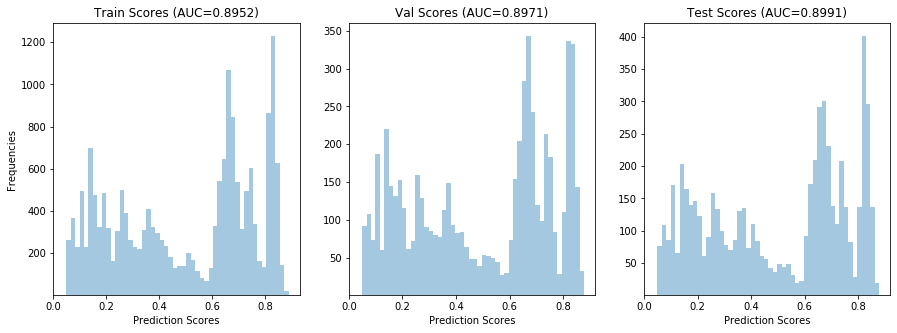

Visualizing SHAP values of VAL examples...


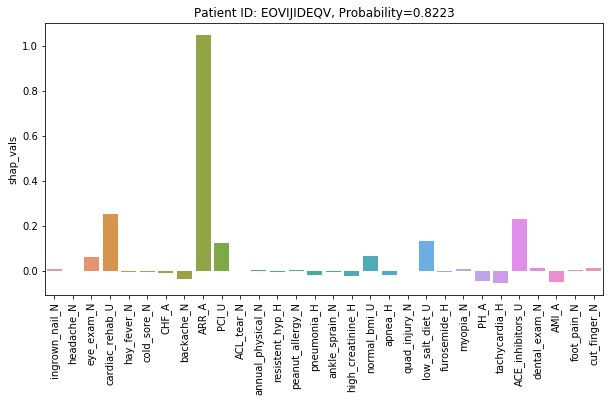

[0, 0, 3, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0]


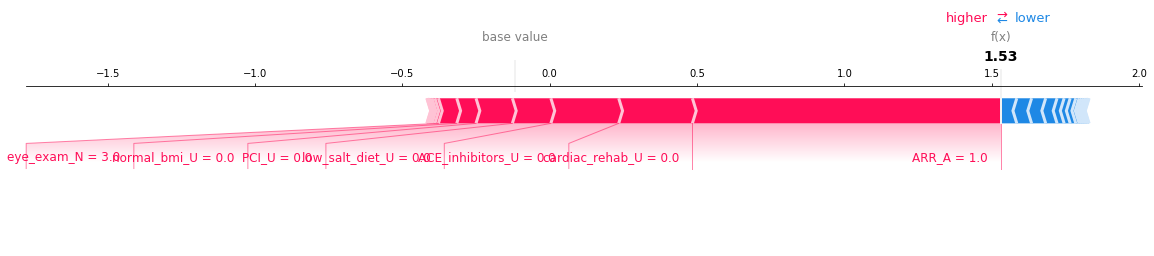

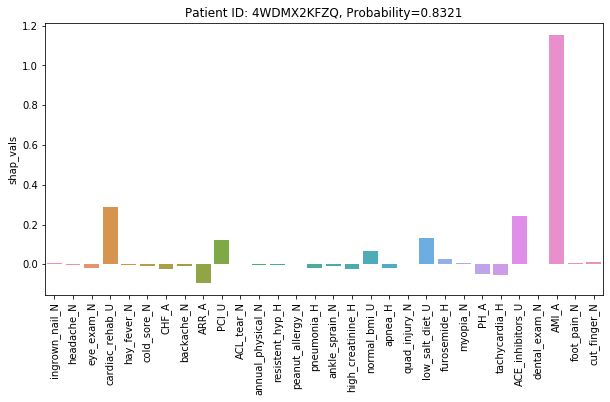

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]


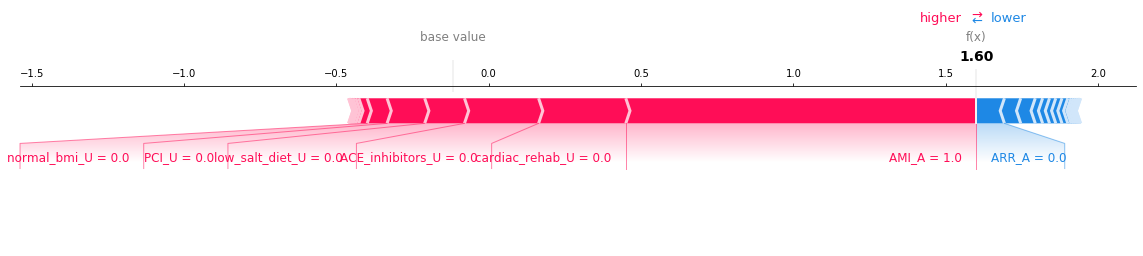

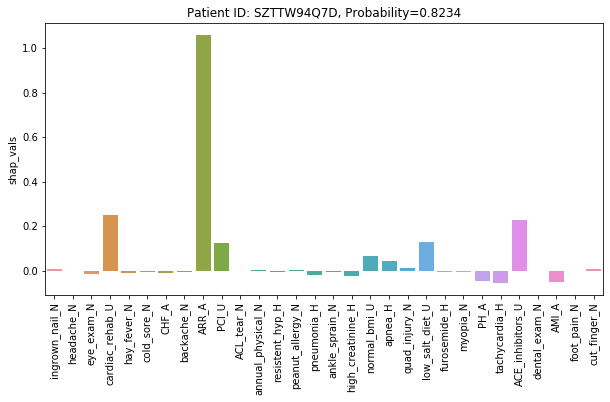

[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 3, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


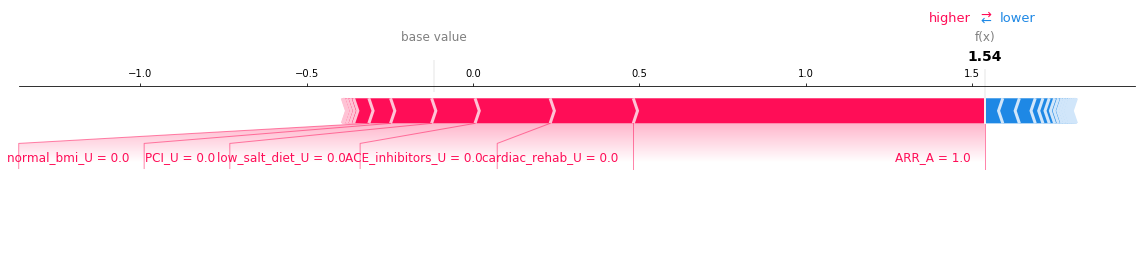

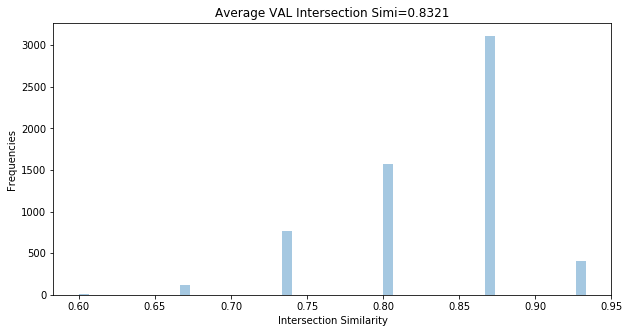

Visualizing SHAP values of TEST examples...


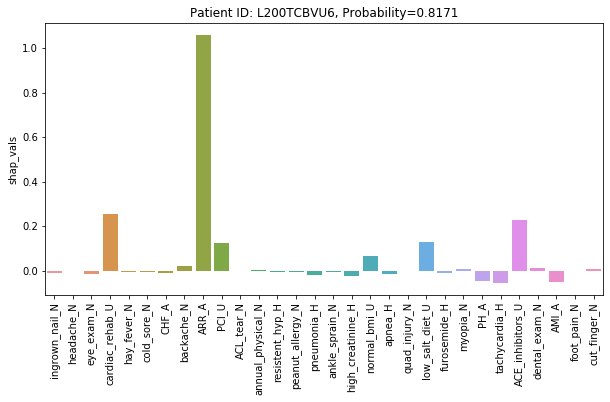

[1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]


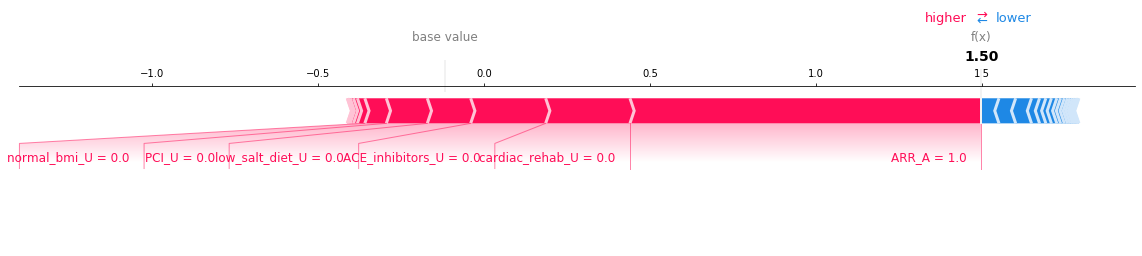

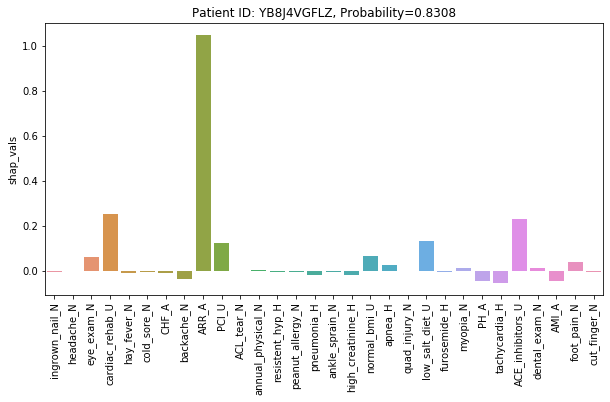

[2, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 3, 0, 4, 2]


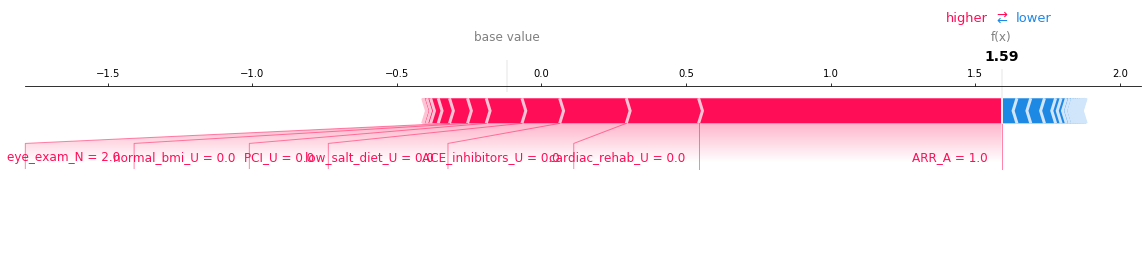

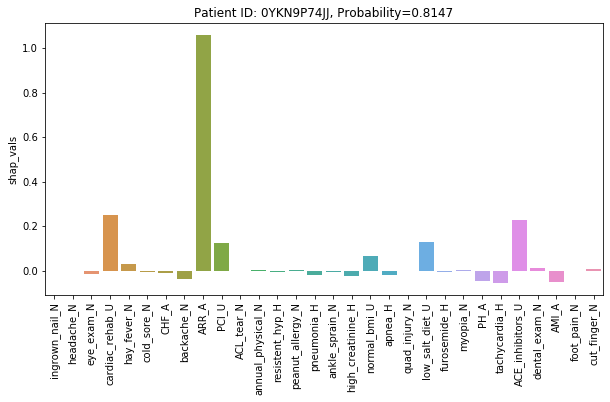

[0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1, 4, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0]


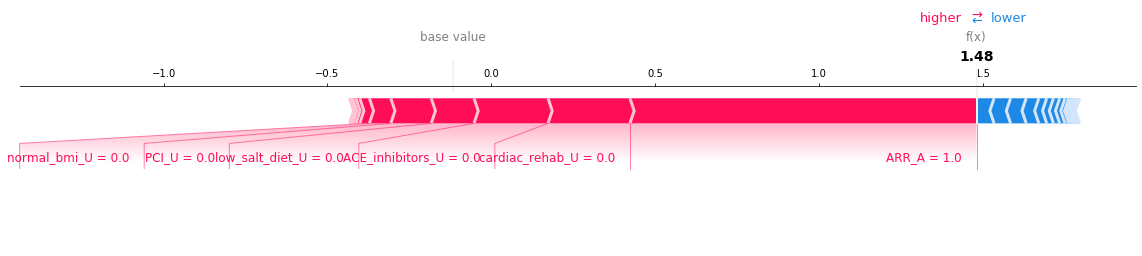

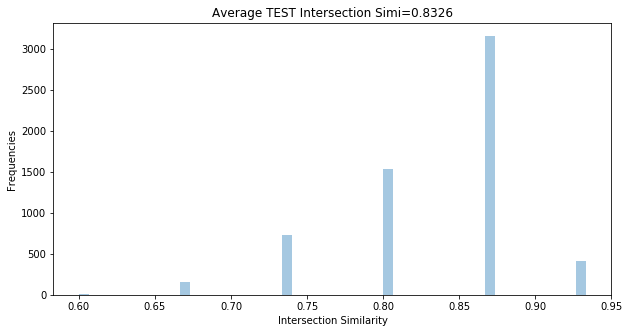

Finally computing and visualizing the global feature importance of the best model....


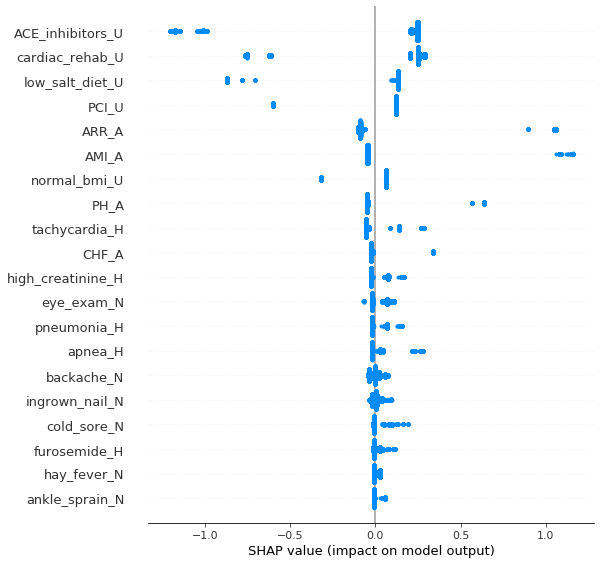

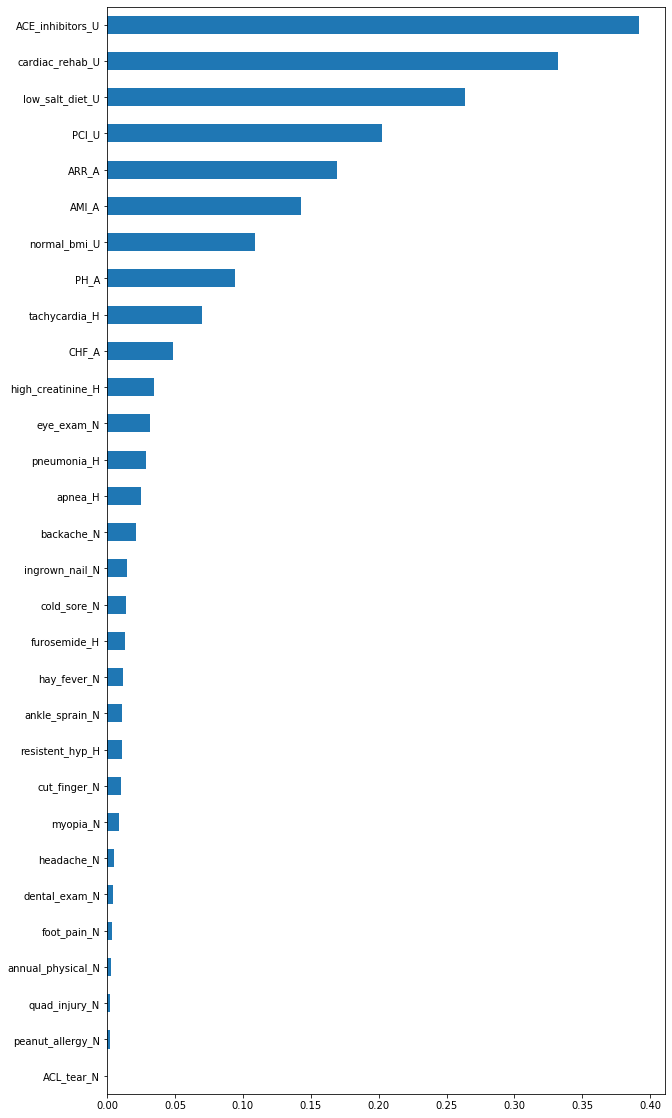

All tasks SUCCESSFULLY completed!


In [158]:
result = compute_shap(
    best_model_info,
    shap_save_path_pattern,
    df_train,
    df_val,
    df_test,
    absolute=True,
    test_positive_only=TEST_POSITIVE_ONLY,
    save_output=SAVE_SHAP_OUTPUT,
    visualize=True,
)

### XGB Built-in Feature Importances

In [159]:
TUNING_JOB_NAME

'sagemaker-xgboost-210125-1547'

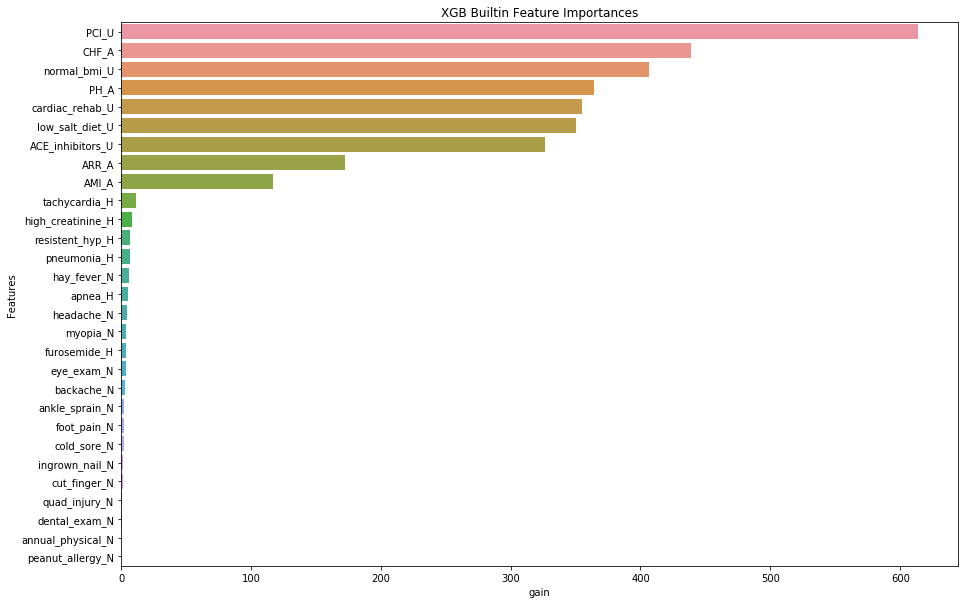

In [160]:
importance_type = "gain"  # Possible values: weight/gain/cover

model_path = best_model_info["local_path"]

xgb_model = xgb_utils.load_model(model_path, remove=False)
importances0 = xgb_model.get_score(importance_type=importance_type)

# Get mapping between the model and actual feature names
feature_names = df_train.columns.tolist()[1:-1]
mappings = dict(zip(xgb_model.feature_names, feature_names))

importances = {}
for k, v in importances0.items():
    importances[mappings[k]] = v
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))

# Plot the feature importances
plt.figure(figsize=(15, 10))
ax = sns.barplot(
    y=list(range(len(list(importances.keys())))),
    x=list(importances.values()),
    orient="h",
)
z = ax.set_yticklabels(list(importances.keys()), rotation=0)
plt.title("XGB Builtin Feature Importances")
plt.xlabel(importance_type)
plt.ylabel("Features")
plt.show()

In [161]:
##Get distribution of dataset

In [162]:
train_data_path

'../../data/toy_dataset/data/30/05/train.csv'

In [163]:
df_tr = pd.read_csv(train_data_path)
df_va = pd.read_csv(valid_data_path)
df_te = pd.read_csv(test_data_path)
print(df_tr.shape, df_va.shape, df_te.shape)

(18000, 33) (6000, 33) (6000, 33)


In [164]:
print(df_tr.shape)
df_tr.head(2)

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2710,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,backache_N,tachycardia_H,hay_fever_N,dental_exam_N,foot_pain_N,ingrown_nail_N,eye_exam_N,quad_injury_N,0,40S1HVN02C
1,2265,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,myopia_N,cut_finger_N,cold_sore_N,normal_bmi_U,pneumonia_H,annual_physical_N,peanut_allergy_N,0,0VRRSQZL1D


In [165]:
X_tr = df_tr.iloc[:, 1:-2]
y_tr = df_tr.iloc[:, -2]
tr_pos_rows = y_tr == 1
X_tr_pos = X_tr[tr_pos_rows]
y_tr_pos = y_tr[tr_pos_rows]
tr_neg_rows = y_tr == 0
X_tr_neg = X_tr[tr_neg_rows]
y_tr_neg = y_tr[tr_neg_rows]

X_va = df_va.iloc[:, 1:-2]
y_va = df_va.iloc[:, -2]
va_pos_rows = y_va == 1
X_va_pos = X_va[va_pos_rows]
y_va_pos = y_va[va_pos_rows]
va_neg_rows = y_va == 0
X_va_neg = X_va[va_neg_rows]
y_va_neg = y_va[va_neg_rows]

X_te = df_te.iloc[:, 1:-2]
y_te = df_te.iloc[:, -2]
te_pos_rows = y_te == 1
X_te_pos = X_te[te_pos_rows]
y_te_pos = y_te[te_pos_rows]
te_neg_rows = y_te == 0
X_te_neg = X_te[te_neg_rows]
y_te_neg = y_te[te_neg_rows]

In [166]:
freqs = dict(Counter(X_te.values.flatten()))
del freqs["<pad>"]

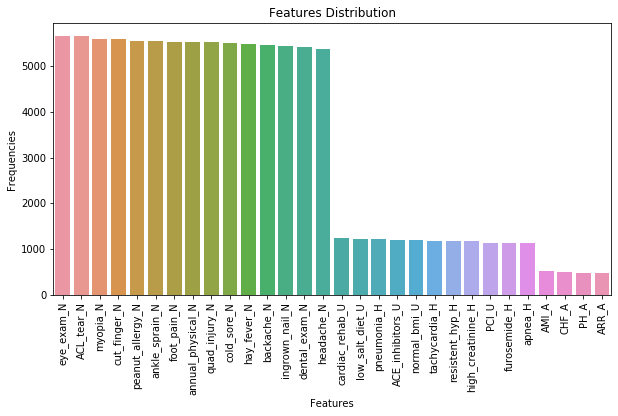

In [167]:
freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

# Plot the feature importances
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x=list(range(len(list(freqs.keys())))),
    y=list(freqs.values()),
    orient="v",
)
z = ax.set_xticklabels(list(freqs.keys()), rotation=90)
plt.title("Features Distribution")
plt.xlabel("Features")
plt.ylabel("Frequencies")
plt.show()